### General setup

In [2]:
%matplotlib widget

In [3]:
import fiftyone as fo
import fiftyone.zoo as foz

In [46]:
import pandas as pd
from random import shuffle

In [55]:
import tensorflow as tf
from object_detection.utils import dataset_util

In [71]:
from PIL import Image

In [70]:
import io

Set download location

In [4]:
import pathlib
datasets_path = pathlib.Path().resolve() / "raw_datasets"
fo.config.dataset_zoo_dir = datasets_path

List avaialble datasets

In [5]:
fo.list_datasets()

['bdd100k-train',
 'bdd_train_6000',
 'coco-2017-train-12000',
 'kitti-train',
 'kitti_train_6000']

## Raw dataset preparation

If Raw datasets already preapred "Raw dataset preparation" can be skipped - move to "TF Record CReation"

### KITTI Dataset

#### Training and Validation

In [51]:
kitti_train = foz.load_zoo_dataset("kitti", split="train")

Split 'train' already downloaded
Loading existing dataset 'kitti-train'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


Extract 20% from training set for validation

In [57]:
index = int(len(kitti_train) * 0.8)
kitti_train_view = kitti_train.shuffle()[:index]
kitti_validation_view = kitti_train.shuffle()[index:]

Check if all images are used and none is duplicated (due to rounding of index)

In [59]:
len(kitti_train_view) + len(kitti_validation_view) == len(kitti_train)

True

In [62]:
kitti_train_6000 = fo.Dataset()
kitti_train_6000.merge_samples(kitti_train_view)
kitti_train_6000.name = 'kitti_train_6000'

#### Test

In [ ]:
kitti_test = foz.load_zoo_dataset("kitti", split="test")

Dataset operations

In [5]:
view = kitti_train.view()

In [ ]:
view.take(len(view)).first()

In [ ]:
x = view.take(10).first()
gt = x.ground_truth
gt.detections[0]
x.filepath

### COCO Dataset

In [49]:
def download_coco(split, max_samples):
    # Restarting download after connection timeout
    try:
        coco_train = fo.zoo.load_zoo_dataset("coco-2017", split=split, label_types=["detections"], classes=["person", "bicycle", "car", "motorcycle", "bus", "train", "truck", 
        "traffic light", "fire hydrant", "parking meter", "bench", "cat", "dog", "chair", "couch", "bed", "dining table", "tv", "laptop"], only_matching=True, max_samples=max_samples)
    except:
        coco_train = download_coco(split, max_samples)

    return coco_train

In [50]:
coco_train = download_coco('train', 12000)

Found annotations at 'D:\_moje\AGH\Magisterka\Master-Thesis\model_training\OD\data\raw_datasets\coco-2017\raw\instances_train2017.json'
11798 images found; downloading the remaining 202
 100% |██████████████████| 202/202 [22.0s elapsed, 0s remaining, 10.0 images/s]     
Writing annotations for 12000 downloaded samples to 'D:\_moje\AGH\Magisterka\Master-Thesis\model_training\OD\data\raw_datasets\coco-2017\train\labels.json'
Dataset info written to 'D:\_moje\AGH\Magisterka\Master-Thesis\model_training\OD\data\raw_datasets\coco-2017\info.json'
Loading 'coco-2017' split 'train'
 100% |█████████████| 12000/12000 [44.4s elapsed, 0s remaining, 228.1 samples/s]      
Dataset 'coco-2017-train-12000' created


In [ ]:
coco_validation = download_coco('validation', 2400)

In [ ]:
coco_test = download_coco('test', 2400)

### BDD Dataset

#### Training

In [4]:
bdd_train = foz.load_zoo_dataset(
    "bdd100k",
    split="train",
    source_dir=r'raw_datasets/bdd100k/',
)

Preparing split 'train' in 'D:\_moje\AGH\Magisterka\Master-Thesis\model_training\OD\data\raw_datasets\bdd100k\train'
Preparing training images...
Preparing training labels...
Preparing validation images...
Preparing validation labels...
Preparing test images...
Parsing dataset metadata
Found 70000 samples
Dataset info written to 'D:\_moje\AGH\Magisterka\Master-Thesis\model_training\OD\data\raw_datasets\bdd100k\info.json'
Loading 'bdd100k' split 'train'
 100% |█████████████| 70000/70000 [1.0h elapsed, 0s remaining, 42.3 samples/s]      
Dataset 'bdd100k-train' created


Take only 6000 images from shuffled dataset

In [17]:
bdd_train_view = bdd_train.view()
bdd_train_view = bdd_train_view.shuffle()[:6000]

Save view as a new dataset

In [46]:
bdd_train_6000 = fo.Dataset()
bdd_train_6000.merge_samples(bdd_train_view)
bdd_train_6000.name = 'bdd_train_6000'

#### Validation

In [ ]:
bdd_validation = foz.load_zoo_dataset(
    "bdd100k",
    split="validation",
    source_dir=r'raw_datasets/bdd100k/',
)

#### Test

In [ ]:
bdd_test = foz.load_zoo_dataset(
    "bdd100k",
    split="test",
    source_dir=r'raw_datasets/bdd100k/',
)

## Load datasets from disk

No need to run this if "Raw dataset preparation" was run in this session

Train datasets

In [6]:
kitti_train_6000 = fo.load_dataset('kitti_train_6000')
bdd_train_6000 = fo.load_dataset('bdd_train_6000')
coco_train = fo.load_dataset('coco-2017-train-12000')

## TF Record Creation

Need to preproces data only once

### Preprocess data

Delete images without labels and containing only "traffic sign" label from BDD Dataset

In [ ]:
def preprocess_bdd(ds):
    dropped_ids = []
    for img in ds:
        if img.detections:
            det_labels = []
            for det in img.detections.detections:
                det_labels.append(det.label)
            det_labels = set(det_labels)
            if len(det_labels) == 1 and "traffic sign" in det_labels:
                dropped_ids.append(img.id)
        else:
            dropped_ids.append(img.id)

    ds.delete_samples(dropped_ids)
    ds.save()

    return ds

In [ ]:
bdd_train_6000 = preprocess_bdd(bdd_train_6000)

Delete images without labels and with labels containig only "Misc" or "DontCare" from KITTI dataset

In [ ]:
def preprocess_kitti(ds):
    correct_labels = ["Car", "Pedestrian", "Van", "Cyclist", "Truck", "Tram", "Person_sitting"]

    dropped_ids = []
    for img in ds:
        det_labels = []
        for det in img.ground_truth.detections:
            det_labels.append(det.label)
        for label in correct_labels:
            if label in det_labels:
                break
            dropped_ids.append(img.id)

    ds.delete_samples(dropped_ids)
    ds.save()

    return ds

In [155]:
kitti_train_6000 = preprocess_kitti(kitti_train_6000)

### Input datasets statistics

In [ ]:
class DatasetStats:
    def __init__(self, bdd, kitti, coco):
        self.bdd_dataset = bdd
        self.kitti_dataset = kitti
        self.coco_dataset = coco

        coco_labels = self.get_gt_labels(coco)
        bdd_labels = self.get_detection_labels(bdd)
        kitti_labels = self.get_gt_labels(kitti)

        self.bdd = pd.DataFrame({"labels": bdd_labels})
        self.coco = pd.DataFrame({"labels": coco_labels})
        self.kitti = pd.DataFrame({"labels": kitti_labels})

    def get_detection_labels(self, ds):
        labels = []
        for img in ds:
            for det in img.detections.detections:
                labels.append(det.label)
        
        return labels

    def get_gt_labels(self, ds):
        labels = []
        for img in ds:
            for det in img.ground_truth.detections:
                labels.append(det.label)


In [ ]:
dataset_stats = DatasetStats(bdd_train_6000, kitti_train_6000, coco_train)

In [ ]:
dataset_stats.coco.value_counts()

In [ ]:
dataset_stats.kitti.value_counts()

In [ ]:
dataset_stats.bdd.value_counts()

### TFRecord blueprint as DataFrame

Map datasets default labels to expected labels:

        1 - person
        2 - car
        3 - big_car
        4 - bike
        5 - train
        6 - traffic_light
        7 - animal
        8 - obstacle


In [33]:
class DFHandler:
    def prepare_input(self, data, ids, filenames, bounding_boxes, labels):
        for bbox, label in zip(data['bboxes'], data['labels']):
            ids.append(data["id"])
            filenames.append(data['filename'])
            bounding_boxes.append(bbox)
            labels.append(label)

        return ids, filenames, bounding_boxes, labels

    def handle(self, dataset, ids, filenames, bounding_boxes, labels):
        for img in dataset:
            data = self.preprocess_data(img)
            ids, filenames, bounding_boxes, labels = self.prepare_input(data, ids, filenames, bounding_boxes, labels)

        return ids, filenames, bounding_boxes, labels




In [34]:
class COCOHandler(DFHandler):
    label_map = {
        "person": 1,
        "car": 2,
        "chair": 8,
        "dining table": 8,
        "traffic light": 6,
        "truck": 3,
        "bench": 8,
        "motorcycle": 4,
        "bicycle": 4,
        "dog": 7,
        "bus": 3,
        "couch": 8,
        "tv": 8,
        "laptop": 8,
        "train": 5,
        "cat": 7,
        "bed": 8,
        "fire hydrant": 8,
        "parking meter": 8,
    }

    def preprocess_data(self, data):
        labels = []
        bboxes = []
        for detection in data.ground_truth.detections:
            bboxes.append(detection.bounding_box)
            labels.append(self.label_map[detection.label])

        return {"id": f"{data['id']}_coco", 'filename': data["filepath"], "labels": labels, "bboxes":bboxes}

In [35]:
class BDDHandler(DFHandler):
    label_map = {
        'traffic light': 6,
        'car': 2,
        'person': 1,
        'motor': 4,
        'bus': 3,
        'truck': 3,
        'bike': 4,
        'train': 5,
    }

    def preprocess_data(self, data):
        labels = []
        bboxes = []
        for detection in data.detections.detections:
            if detection.label in self.label_map:
                bboxes.append(detection.bounding_box)
                labels.append(self.label_map[detection.label])

        return {"id": f"{data['id']}_bdd", 'filename': data["filepath"], "labels": labels, "bboxes":bboxes}

In [36]:
class KITTIHandler(DFHandler):
    label_map = {
        'Car': 2,
        'Van': 3,
        'Pedestrian': 1,
        'Truck': 3,
        'Cyclist': 4,
        'Tram': 5,
        'Person_sitting': 1
    }

    def preprocess_data(self, data):
        labels = []
        bboxes = []
        for detection in data.ground_truth.detections:
            if detection.label in self.label_map:
                bboxes.append(detection.bounding_box)
                labels.append(self.label_map[detection.label])

        return {"id": f"{data['id']}_kitti", 'filename': data["filepath"], "labels": labels, "bboxes":bboxes}

In [ ]:
def create_pandas_blueprint(coco_ds, bdd_ds, kitti_ds):
    coco_handler = COCOHandler()
    bdd_handler = BDDHandler()
    kitti_handler = KITTIHandler()

    id, filename, boxes, labels = coco_handler.handle(coco_ds, [], [], [], [])
    id, filename, boxes, labels = bdd_handler.handle(bdd_ds, id, filename, boxes, labels)
    id, filename, boxes, labels = kitti_handler.handle(kitti_ds, id, filename, boxes, labels)

    return pd.DataFrame({"id": id,"filename": filename, "bboxes": boxes, "label": labels})

In [39]:
dataset_df = create_pandas_blueprint(coco_train, bdd_train_6000, kitti_train_6000)

In [169]:
import matplotlib.pyplot as plt
import cv2

In [203]:
len(dataset_df)

179521

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


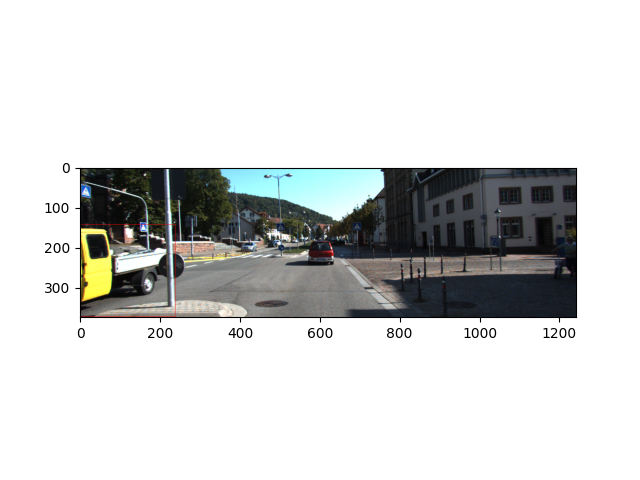

In [211]:
coco = dataset_df.loc[170000]
img = plt.imread(coco['filename'])

img = cv2.rectangle(img, (int(img.shape[1] * coco['bboxes'][0]), int(img.shape[0] * coco['bboxes'][1])), 
(int((coco['bboxes'][0] + coco['bboxes'][2]) * img.shape[1]), int((coco['bboxes'][1] + coco['bboxes'][3]) * img.shape[0])), 
(125, 0, 0), 1)

plt.imshow(img)

plt.show()

In [209]:
coco['id']

'634ea1af171395f6eb70e9ca_kitti'

In [206]:
coco['label']

6

In [191]:
coco['bboxes']

[0.3483991683991684, 0.25451562499999997, 0.6457588357588357, 0.726859375]

In [193]:
coco_train['634e9fbc42bd0e0a4cf573b3'].ground_truth

<Detections: {
    'detections': [
        <Detection: {

            'id': '634e9fbc42bd0e0a4cf573b2',

            'attributes': {},

            'tags': [],

            'label': 'person',

            'bounding_box': [

                0.3483991683991684,

                0.25451562499999997,

                0.6457588357588357,

                0.726859375,

            ],

            'mask': None,

            'confidence': None,

            'index': None,

            'supercategory': 'person',

            'iscrowd': 0,

        }>,
    ],
}>

### Write TFRecords

In [145]:
class Sample:
    label_map = {
        1: "person".encode('utf8'),
        2: "car".encode('utf8'),
        3: "big_car".encode('utf8'),
        4: "bike".encode('utf8'),
        5: "train".encode('utf8'),
        6: "traffic_light".encode('utf8'),
        7: "animal".encode('utf8'),
        8: "obstacle".encode('utf8')
    }

    def __init__(self, data):
        self.filename = data['filename'].encode('utf8')
        self.source_id = self.filename

        self.encoded_image = self.get_encoded_image(data)
        
        height, width, format = self.get_image_data(data)
        self.height, self.width, self.format = height, width, format
        
        self.label = []
        self.text = []
        self.xmin, self.xmax, self.ymin, self.ymax = [], [], [], []

    def get_encoded_image(self, data):
        with tf.io.gfile.GFile(data['filename'], 'rb') as fid:
            encoded_jpg = fid.read()

            if encoded_jpg == b'': raise IOError('Corrupted file')
        return encoded_jpg

    def get_image_data(self, data):
        encoded_jpg_io = io.BytesIO(self.encoded_image)
        image = Image.open(encoded_jpg_io)
        width, height = image.size

        image_format = data['filename'][-3:].encode('utf8')

        return height, width, image_format

    def add_bounding_box(self, data):
        self.xmin.append(data['bboxes'][0])
        self.xmax.append(data['bboxes'][0] + data['bboxes'][2])
        self.ymin.append(data['bboxes'][1])
        self.ymax.append(data['bboxes'][1] + data['bboxes'][3])

    def add_label(self, data):
        self.label.append(data['label'])
        self.text.append(self.label_map[data['label']])

In [146]:
class TFRecordWriter:
  
    def __init__(self, dataset_df, path, type):
        self.df = dataset_df
        self.type = type
        self.path = path

    def write_record(self):
        ids = self.prepare_index()
        self.open_file()

        for id in ids:
            data = self.df.query(f'id == "{id}"')
            try:
                sample = Sample(data.iloc[0])

                for index, row in data.iterrows():
                    sample.add_bounding_box(row)
                    sample.add_label(row)

                    tf_example = self.create_tf_example(sample)
                    self.write_to_file(tf_example) 

            except IOError:
                pass
            
        self.close_file

    def prepare_index(self):
        return shuffle(dataset_df["id"].unique())

    def open_file(self):
        self.writer = tf.io.TFRecordWriter(rf"{self.path}/{self.type}.records")

    def write_to_file(self, tf_example):
        self.writer.write(tf_example.SerializeToString()) 

    def close_file(self):
        self.writer.close()

    def create_tf_example(self, sample):

        tf_example = tf.train.Example(features=tf.train.Features(feature={
            'image/height': dataset_util.int64_feature(sample.height),
            'image/width': dataset_util.int64_feature(sample.width),
            'image/filename': dataset_util.bytes_feature(sample.filename),
            'image/source_id': dataset_util.bytes_feature(sample.source_id),
            'image/encoded': dataset_util.bytes_feature(sample.encoded_image),
            'image/format': dataset_util.bytes_feature(sample.format),
            'image/object/bbox/xmin': dataset_util.float_list_feature(sample.xmin),
            'image/object/bbox/xmax': dataset_util.float_list_feature(sample.xmax),
            'image/object/bbox/ymin': dataset_util.float_list_feature(sample.ymin),
            'image/object/bbox/ymax': dataset_util.float_list_feature(sample.ymax),
            'image/object/class/text': dataset_util.bytes_list_feature(sample.text),
            'image/object/class/label': dataset_util.int64_list_feature(sample.label),
        }))
        return tf_example


In [147]:
tf_record_writer = TFRecordWriter(dataset_df, r"prepared_datasets", "train")
tf_record_writer.write_record()